# Setup

In [1]:
import nltk
import time
import re
import numpy as np
import pandas as pd
import twint
import json
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools FOR TOPIC MODELING
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional  (I HAVEN'T USED THIS YET)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words -------------- ADD TO THESE AS WE SEE FIT
from nltk.corpus import stopwords

import pickle

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# TWINT SCRAPING FROM TWITTER 

---

SEE https://github.com/twintproject/twint for options. The following cell returns a .csv file from all tweets containing 'Coronavirs' since the time specified by the [--since] option, in the [--lang] of english (en), and the csv file gets named after whatever iteration of scraping it is plus useful search parameters in the file name.


---

In [2]:
# THE TWINT COMMAND I USE IN TERMINAL TO SCRAPE

# twint -s Coronavirus --since "2020-03-24 20:00:00" --lang en -o just_cv_en_2 --csv

# Importing and Prepocessing 

---

**Open the corpus_pipeline to make changes, I'm sure there's lots of ways to clean tweets beyond simply regexing for emails and new line characters, probably way more preprocessing we can do, especially with .extending the stopwords.**

---

In [3]:
df3 = pd.read_csv('./just_cv/twint_3_en.csv')

In [4]:
df3.shape

(14400, 34)

In [5]:
df4 = pd.read_csv('./just_cv/twint_4_en.csv')

In [6]:
df4.shape

(14399, 34)

In [7]:
df5 = pd.read_csv('./just_cv/twint_5_en.csv')

In [8]:
df5.shape

(14399, 34)

In [9]:
df6 = pd.read_csv('./just_cv/twint_6_en.csv')

In [10]:
df6.shape

(14399, 34)

In [11]:
df7 = pd.read_csv('./just_cv/twint_7_en.csv')

In [12]:
df7.shape

(14400, 34)

In [13]:
df8 = pd.read_csv('./just_cv/twint_8_en.csv')

In [14]:
df8.shape

(13719, 34)

In [15]:
data3 = df3.tweet.values

In [16]:
data4 = df4.tweet.values

In [17]:
data5 = df5.tweet.values

In [18]:
data6 = df6.tweet.values

In [19]:
data7 = df7.tweet.values

In [20]:
data8 = df8.tweet.values

In [21]:
data = np.concatenate([data3, data4, data5, data6, data7, data8])

In [22]:
data.shape

(85716,)

In [23]:
data

array(['I said they are better than nothing, not that they are as good as the medical ones. There was no "bare face" group to fully show how effective the cloth masks are. The cloth masks are not meant to protect you from coronavirus, they are there to catch at least some of the 1/2',
       'Oops: CNN Forgot To Translate Its Latest Coronavirus Update From Mandarin |   https://babylonbee.com/news/cnn-embarassed-after-forgetting-to-translate-latest-coronavirus-update-from-mandarin-before-publishing\xa0…',
       'Speeding up https://twitter.com/ryanfiredragon/status/1242886374963007493\xa0…',
       ...,
       'Maybe, his death will save the lives of his congregation. Covid19 is not a hoax.\n#CoronaVirus  https://twitter.com/cherijacobus/status/1243347684385271808\xa0…',
       'y’all go watch this corona virus movie,it was released in 2018 .Episode 10  pic.twitter.com/GE0eVfqKQY',
       '@USDOL just released this to workplaces across the US. #KnowYourRights #Coronavirus #COVID19 #USD

In [153]:
types = []
for i in data:
    types.append(type(i))

In [154]:
index = 0
non_str = {}
fake = []
for i in data: 
    if type(i) != str:
        non_str[index] = type(i)
    index += 1

In [155]:
for i in non_str:
    data = np.delete(data, i)

In [156]:
df = pd.DataFrame()

df['tweets'] = data

In [157]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

df['sentiment'] = [analyser.polarity_scores(i) for i in df['tweets']]

df['compound_sentiment'] = [i['compound'] for i in df['sentiment']]
df['sentiment'] = df['compound_sentiment']
df.drop(columns=['compound_sentiment'], inplace=True)

In [158]:
filtered_sentiment_df = df.loc[(df['sentiment'] < -.40) ^ (df['sentiment'] > .40)]

In [159]:
data = filtered_sentiment_df.tweets.values

In [186]:
more = ["news","case","make","would","death","spread","story","still","stop","kill","com", "twitter","pic","say","https"]
more2 = ["help","work","time","new","covid","get","test","day","http","country","good","world","may","government","pat", 'virus']
more3 = ["due","stay","be","report","worker","bill","back","first","people","corona", 'saying', 'getting', 'pandemic', 'state', 'china', 'covid19']
more4 = ["go","die","take","see","know","status","call",'Go','Say', 'www', 'many', 'see', 'make', 'want', 'be', 'could', "s", 'tell', 'today']
more5 = ['Let', 'being', 'going','case', 'make', 'also', 'let', 'coronavirus', 'Coronavirus', 'Corona', 'must', 'much', 'thing', 'keep', 'even']
more6 = ['need', 'like', 'one', 'thank', 'html', 'covid2019', 'getting', 'making', 'coming', 'saying']


In [162]:
more.extend(more2)

In [163]:
more.extend(more3)

In [164]:
more.extend(more4)

In [165]:
more.extend(more5)

In [175]:
more.extend(more6)

In [176]:
stop_words = stopwords.words('english')

In [177]:
len(more)

87

In [178]:
len(stop_words)

179

In [179]:
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [180]:
stop_words.extend(more)

In [181]:
len(stop_words)

271

**The following returns the [id2word] dictionary, [texts] which is the lemmatized data, and [corpus] which is the corpus.**

In [182]:
def corpus_pipeline(data):  
    # ********    THE FOLLOWING REGEXES SHOULD PROBABLY BE HEAVILY MODIFIED FOR CUSTOMIZING TWEETS CLEANING  *************
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(data))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # **********   ALSO PROBABLY REQUIRES EXTENSIVE ADDING OF TWEET-SPECIFIC STOPWORDS   ***********
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    
    data_words_trigrams = make_trigrams(data_words_bigrams)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return id2word, texts, corpus

# Pipeline for Dict, Texts, Corpus

In [183]:
id2word, texts, corpus = corpus_pipeline(data)

# LDA Model

In [184]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [191]:
lda_model.show_topics()

[(0,
  '0.022*"home" + 0.016*"support" + 0.014*"event" + 0.014*"be" + 0.014*"give" + 0.014*"hospital" + 0.014*"business" + 0.014*"health" + 0.013*"safe" + 0.011*"get"'),
 (1,
  '0.057*"virus" + 0.021*"sign" + 0.019*"boris_johnson_demand" + 0.014*"fear" + 0.013*"article" + 0.012*"come" + 0.012*"thank" + 0.011*"make" + 0.011*"relief" + 0.010*"week"'),
 (2,
  '0.028*"outbreak" + 0.025*"say" + 0.018*"fight" + 0.017*"petition" + 0.016*"death" + 0.014*"s" + 0.014*"way" + 0.013*"economy" + 0.012*"live" + 0.011*"really"'),
 (3,
  '0.029*"crisis" + 0.026*"trump" + 0.017*"case" + 0.014*"think" + 0.013*"die" + 0.013*"watch" + 0.013*"update" + 0.011*"video" + 0.010*"life" + 0.009*"use"'),
 (4,
  '0.030*"need" + 0.023*"tackle" + 0.017*"lockdown" + 0.013*"job" + 0.012*"bad" + 0.011*"free" + 0.011*"share" + 0.010*"number" + 0.010*"money" + 0.010*"call"')]

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

# Topic Assignment to Original Tweets

In [71]:
final_topics = []
for i in corpus:  
    topics = lda_model.get_document_topics(i)

    probs = {}
    for i in topics:
        probs[i[0]] = i[1]

    topic = max(probs, key=probs.get)
    final_topics.append(topic)

In [72]:
len(final_topics)

27890

In [73]:
df_final = filtered_sentiment_df.copy()

In [74]:
df_final['topic'] = final_topics

In [75]:
topic_dict = {0: 'public_health',
              1: 'boris',
              2: 'economy',
              3: 'trump',
              4: 'employment'}

In [76]:
df_final['topic_defined'] = df_final.topic.apply(lambda x: topic_dict[x])

In [77]:
df_final

,tweets,sentiment,topic,topic_defined
0,"I said they are better than nothing, not that ...",0.6984,1,boris
3,"Texas Gov. Greg Abbott, who routinely overrule...",0.6369,4,employment
4,"Other than Satan, is there anyone more evil th...",-0.6901,1,boris
5,Doctors say vitamin D3 may be helpful in comba...,0.6124,2,economy
6,JUST IN: COVID-19: Edo Speaker tests positive ...,0.5574,1,boris
...,...,...,...,...
57577,Russell Westbrook’s (@russwest44) efforts to a...,0.5719,1,boris
57581,My friend got a cat and I reallllllly wanna go...,0.7140,4,employment
57584,Too bad we can't project this coronavirus onto...,-0.7579,3,trump
57586,Keep seeing versions of this take blaming New ...,-0.9152,3,trump


In [78]:
df_final.groupby('topic_defined')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
topic_defined,,,,,,,,
boris,10647.0,0.039370,0.641466,-0.9935,-0.5994,0.4215,0.59940,0.9928
economy,2168.0,-0.185881,0.634047,-0.9874,-0.7059,-0.5267,0.51060,0.9841
employment,3344.0,-0.092787,0.648893,-0.9842,-0.6597,-0.4517,0.55740,0.9784
public_health,6887.0,0.118804,0.652031,-0.9902,-0.5719,0.4522,0.69080,0.9862
trump,4844.0,-0.239385,0.612362,-0.9886,-0.7088,-0.5423,0.47275,0.9917


In [79]:
trump = df_final.loc[(df_final.topic_defined == 'trump')]

In [80]:
worst5vals = sorted(trump.sentiment)[10]
worst5vals

-0.9714

In [81]:
trump_worst_5 = trump.loc[trump.sentiment < worst5vals]

In [82]:
trump_worst_5.tweets.values

array(['Feb 2020\nDonald Trump FLOODING 🇺🇸\nDAILY With #coronavirus LIES\n\nVirus is a HOAX from Dems to hurt Trump\nVirus will mysteriously go away\nI have it CONTROLLED\nFLU kills MORE👥\n\nTrump was WARNED of PANDEMIC, HE IGNORED\nWARNINGS\n\nYou a journalist, FLOODING 🇺🇸 with Trump Lies',
       'Angry angry angry \n\n😠😠😠😠😠😠😠😠\n‘Disgraceful’ landlords hold secret prohibition-style pub lock-ins to sell leftover beer despite coronavirus ban – The Sun  https://www.thesun.co.uk/news/11237569/disgraceful-landlords-hold-secret-prohibition-style-pub-lock-ins-to-sell-leftover-beer-despite-coronavirus-ban/\xa0…',
       '😭😭😭😭😭😭Coronavirus latest:\n Italy’s death toll rises by 683 even as new infections slow A further 683 people have died from the #Covid19 virus in Italy over the past 24 hours even as the rate of growth of new infections continued to slow pic.twitter.com/xkU5KnsLUS',
       'Ignoring the Coronavirus Trumps followers are like Hitler and his generals they followed a MAD MAN and

In [83]:
best5vals = sorted(trump.sentiment, reverse=True)[30]

In [84]:
trump_best_5 = trump.loc[trump.sentiment > best5vals]

In [85]:
trump_best_5.tweets.values

array(['Found some funny memes that cover the issues Coronavirus brings lol. 💁🏻\u200d♂️😂👌🙅\u200d♂️😷☣ @ Los Angeles, California  https://www.instagram.com/p/B-KtNOvAZDb/?igshid=1gscz1sst9hqa\xa0…',
       "If you're a #university or work with #students and you feel like this animation would be useful, please share/use/steal this to help spread the word. Happy to send as a video too, just let us know.\n#covid19 #coronavirus #CoronavirusLockdown #SocialDistancing #StayHome #staysafe pic.twitter.com/fnS6nicaMI",
       'Quarantine House Starring...\n\n#coronavirusmemes😂😂😂 #coronavirus #covıd19 #quarantine #funnymemes #sick #corona #stayhome #lol #laugh #laughteristhebestmedicine #instalaugh #haha #jokes  https://www.instagram.com/p/B-KtGZHlC5X/?igshid=14h8kj03avju3\xa0…',
       "coronavirus:\nEvery breath you take\nAnd every move you make\nEvery bond you break\nEvery step you take\nI’ll be watching you\n\nme:\n\xa0I want to break free\nI want to break free\nI want to break free from your 

In [86]:
boris = df_final.loc[(df_final.topic_defined == 'boris')]

In [87]:
worst30vals = sorted(boris.sentiment)[30]
worst30vals

-0.9641

In [88]:
boris_worst_30 = boris.loc[boris.sentiment < worst30vals]

In [89]:
boris_worst_30.tweets.values

array(['People who are negative, or have negative minds are affected by the virus most drastically. They imagine the worst case scenarios (very possibly) and being in fear of the virus can kill them selves through panic and their beliefs. #coronavirus',
       'I miss football\n\nI miss rugby\n\nI miss NBA 😢😢😧😨😨😨\n\nF.U Corona Virus',
       "@RudyHavenstein Our new pet\nSing-a-long with us!\nWinnie the Flu, Winnie the Flu,\nClucky, little sucky all stuffed with mucky.\nHe's Winnie the Flu, Winnie the Flu,\nClingy, stingy, nasty new flu.\n#coronavirus  pic.twitter.com/UupZVFxhxr",
       'All everybody focused on is making a cure for the corona virus n I want somebody to grow weed that’ll keep me high for 24 hrs 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭',
       'Department of health is covering up the first coronavirus death so they don’t scare tourists. How the hell do you fuck up that bad? Bruce Anderson and Sarai park both have to go. Take ige’s ass and Caldwell with them too.',
       'So sad. Italian nu

In [90]:
best30vals = sorted(boris.sentiment, reverse=True)[30]

In [91]:
best30vals

0.9605

In [92]:
boris_best_30 = boris.loc[boris.sentiment > best30vals]

In [93]:
boris_best_30.tweets.values

array(['Lets unite to forget #coronavirus\n🖕🖕U #ChineseVirus\n@realDonaldTrump 🤣🤣🤣\n\nFav Movie; #7amarivu\n( @ARMurugadoss)\n Fav song : #venpanimalarae(#powepandi)\nFav color : #white\nFav actor: @Suriya_offl\nFav Drink : #datesmilkshake\n\nI nominate @arya_offl @VigneshShivN #)@sayyeshaa https://twitter.com/MASTERMiiiiiND/status/1242881837820596224\xa0…',
       "When you thought you had #coronavirus but the doctor says it's just #COVID19 ........What a relief!!! 🥴😅😅😂🤣 #staysafe .",
       "Wow. All over the Twitter? I just came online to check Corona virus news ohh. I saw abegg Trending 🤣😂🤣🤣 account, send, share. A'ah. Is the party over?? I really need me some 10million ohhh....abi e too much?",
       '🔹🔹🔹🔹🔹🔹🔹🔹🔹\n\nWell, here we go!! \n\nNOW PRINCE CHARLES TESTS POSITIVE FOR #CORONAVIRUS \n\nWe KNEW THIS was coming!!\n\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹  https://twitter.com/chrisshipitv/status/1242761154973368320\xa0…',
       'The only absolute positive about coronavirus is the impact it has had on the

In [94]:
economy = df_final.loc[(df_final.topic_defined == 'economy')]

In [95]:
worst30vals = sorted(economy.sentiment)[30]
worst30vals

-0.9476

In [96]:
economy_worst_30 = economy.loc[economy.sentiment < worst30vals]

In [97]:
economy_worst_30.tweets.values

array(["Less have died from the new coronavirus. But you're failing to realise that if it becomes as widespread as the flu, it will kill way more people. Coronavirus spreads easier than flu (R0 value is higher), so without these lockdowns coronavirus deaths will quickly outnumber flu.",
       "Coronavirus death toll in Spain overtakes China - The Guardian: * Coronavirus death toll in Spain overtakes China\xa0\xa0The Guardian * Coronavirus: Spain's death toll surpasses China's - BBC News\xa0\xa0BBC News * Spain's coronavirus death toll surges past China\xa0…  http://dlvr.it/RSYFqj\xa0",
       "People gotta stop saying coronavirus is worse than the flu. I've had the flu. Horrible muscle aches. A fever so high, steam comes off your watery eyes when you blink. Mouth- breathing. Delirium. Tight chest. Cough. The flu is no CAKE-WALK! #coronavirus",
       'Coronavirus really said BITCH YOU THOUGHT 😭😭😭😭😭  https://twitter.com/abbyelectric/status/1229941442149150721\xa0…',
       '#JoeBiden s

In [98]:
best30vals = sorted(economy.sentiment, reverse=True)[30]

In [99]:
best30vals

0.8933

In [100]:
economy_best_30 = economy.loc[economy.sentiment > best30vals]

In [101]:
economy_best_30.tweets.values

array(["Lets all take a moment to commend the marvelous job glorious leader Kim Jong Un has done in containing the coronavirus in the Democratic People's Republic of Korea. 0 cases and 0 deaths to date, an inspiration for every nation who have been unable to contain this.",
       'Yes. Yes. \n"We the People of the United States, in Order to form a more perfect Union: \nPromote the general Welfare, and secure the Blessings of Liberty. \nHow will we secure the Blessings of Liberty if touched by #coronavirus. \nWe are worried about 2020 rather General Welfare',
       "On a conference call with some 200 Democrats to discuss Nancy's Coronavirus Bill Majority Whip James Clyburn (D-S.C.) said:\n\n“THIS IS A TREMENDOUS OPPORTUNITY TO RESTRUCTURE THINGS TO FIT OUR VISION”\n\nWOW!  Can we call them #traitors now? https://www.msn.com/en-us/news/politics/dem-rep-told-colleagues-coronavirus-bill-is-e2-80-98tremendous-opportunity-to-restructure-things-to-fit-our-vision-e2-80-99/ar-BB11A58M\xa0…",


In [102]:
ph = df_final.loc[(df_final.topic_defined == 'public_health')]

In [103]:
ph

,tweets,sentiment,topic,topic_defined
15,A NY Daily News reporter wants to talk to truc...,0.6369,0,public_health
28,Huge thanks to Dr Tosin who kindly did a Q&A w...,0.9531,0,public_health
32,"In the short-term, Clorox is an attractive pla...",0.6486,0,public_health
33,I'm intrigued to learn more about the spread o...,0.7778,0,public_health
42,"At this point, y’all can’t even be mad at Trum...",-0.8053,0,public_health
...,...,...,...,...
57557,Wash Your #Hands!\nUse #Sanitizers!\nWear A #F...,0.6209,0,public_health
57558,‘Coronavirus Lockdown has Already Done More Da...,-0.5413,0,public_health
57564,"Trump sends cease, desist letter on ad featuri...",-0.4939,0,public_health
57568,Gov. Charlie Baker is ordering schools & non-e...,0.4939,0,public_health


In [104]:
worst30vals = sorted(ph.sentiment)[30]
worst30vals

-0.9528

In [105]:
ph_worst_30 = ph.loc[ph.sentiment < worst30vals]

In [106]:
ph_worst_30.tweets.values

array(['I SWEAR IF CHINESE PPL EAT WEIRD ASS FOOD AGSIN THEY SHOULD BE ARRESTED!!  THIS IS KILLING THE WORLD!! #coronavirus',
       "In coronavirus pandemic, Trump allies say they're ready to die  Did these guys miss their appointments last week? They are talking about geriatric genicide.\nHow evil can they get?These guys are manics, fools, and evil!!!",
       "Mother is mother, this is not the time to fight among themselves, It's time to fight together with coronavirus, Let me tell you once, there is still time to stop the fight right now & no one will abuse someone's religion, abuse someone's mother and outrage someone's community!!❌",
       "Eminem's Godzilla, directed by Cole Bennett, which features Dr. Dre n Mike Tyson, was released amid coronavirus pandemic.\n\nWuhan Coronavirus = 222\nMusic to be Murdered By = 222\n\nCole Bennett = 182\nDre born 18/2\nTyson born 182nd day.\nYear of the Rat = 182\nGerm Warfare = 182",
       'Coronavirus can kill a human too quickly but it can

In [107]:
best30vals = sorted(ph.sentiment, reverse=True)[30]

In [108]:
best30vals

0.9703

In [109]:
ph_best_30 = ph.loc[ph.sentiment > best30vals]

In [110]:
ph_best_30.tweets.values

array(['The novel coronavirus may be strong, but our community is stronger. Have you witnessed an act of kindness in your community? No matter how big or small, share it with us using #CommunityGreaterThanCovid19.\nEach entry will be entered into a draw to win a $100 Amazon gift card. pic.twitter.com/hUPE2YDtKX',
       'Thank you my dear baby girl.🥰🥰🥰💜🙏🏽  God bless you Arya . Love you to my dear. \n#We will stop #CORONAVIRUS. #world\n#Godisgood #COVID19 pic.twitter.com/kVoGmWL5tC',
       'Pray the Holy Rosary daily for the graces from God to meet the challenges of the "coronavirus" in Our Country & the whole world.May the Blessed Mother intercede for us with God to be patient, civil, respectful, honest, & cooperative with the many civil inconveniences with WISDOM!',
       "I like your pretty little smile there Cindy. Hope You are safe from the Coronavirus, hope it ends soon. I don't think anyone wants to spend Summer in Confinement. Have a Wicked Wednesday Cindy, You're a Beautiful 

In [133]:
emp = df_final.loc[(df_final.topic_defined == 'employment')]

In [134]:
worst30vals = sorted(emp.sentiment)[30]
worst30vals

-0.9527

In [135]:
emp_worst_30 = emp.loc[emp.sentiment < worst30vals]

In [136]:
emp_worst_30.tweets.values

array(['Really impt discussion of how much racism coronavirus has stirred up! I know we\'re all just trying to stay safe but it\'s so shocking and disappointing to see people retaliate violently 😞 YEAR OF THE OX - "VIRAL" MV | Coronavirus Message  https://youtu.be/BGWJGM-wsV4\xa0 via @YouTube',
       'Instead of drunk tweeting I could be learning useful things on YouTube like how to braid my own hair, fold a fitted sheet, chop an onion, cure the coronavirus so I can drink in a bar 😭😭😭😭😭😭😭😭',
       '#POLITICIANS and #Media #Advertising ... EXPLOITING people ...interrupting normal programing for the same BS. Use your normal news hour for this crap! We get it you MORONS. STOP the non-STOP coronaVIRUS crap. We get it ... OMG! It is SICKENING you are making people SICK!',
       'I am reminded of what Trump\'s Econ prof at Penn said. "He was the dumbest goddam student I ever had." And it makes sense why Trump didn\'t mention his Administration\'s catastrophic FAILURE ON TESTS for #Coronav

In [199]:
best100vals = sorted(emp.sentiment, reverse=True)[100]

In [200]:
best100vals

0.8834

In [201]:
emp_best_100 = emp.loc[emp.sentiment > best100vals]

In [202]:
emp_best_100.tweets.values

array(['Totally! Healing everything from babies bums to the spotty face of a 33 y/o to the bedsores of the elderly. It is a miracle! Wonder if it would work on Coronavirus! 🤣🤣🤣',
       '#Sensex #coronavirus episode will make India a much more confident economy after learning great lessons at #WFH, personal hygiene , and respect for law, Doctors and science!  Overall, much better future awaits #IndianEconomy',
       'Hey @CNN, it would be really great of you could report on how governments/health care systems in Singapore and S. Korea have responded to the COVID epidemic: shutdowns, contagion tracking, testing, care provided, care cost coverage, etc. So much to learn for the US. #coronavirus',
       'Great @CityAM piece with @londonchamber member @BromptonBicycle @Will_Brompton about the impact of #coronavirus on their export to 47 countries, & their generous provision of Brompton Bikes to NHS staff. Great stuff 👏🏻  https://www.cityam.com/brompton-boss-calls-for-long-term-thinking/\x

# Visualizing and Findings

In [111]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

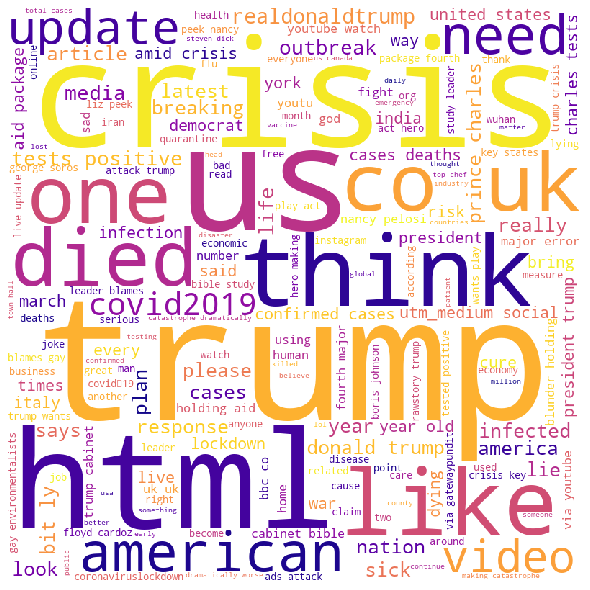

In [123]:

comment_words = ' '
stopwords = stop_words
  
# iterate through the csv file 
for val in trump.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap = 'plasma').generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

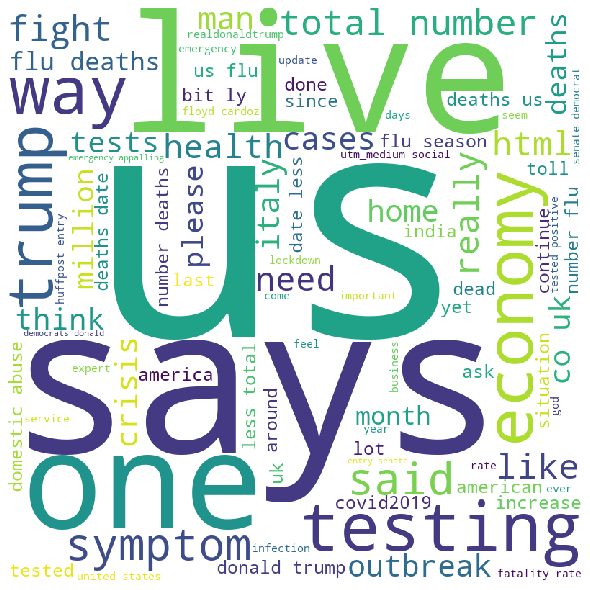

In [124]:

comment_words = ' '
stopwords = stop_words 
  
# iterate through the csv file 
for val in economy.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [125]:
boris.tweets.values

array(['I said they are better than nothing, not that they are as good as the medical ones. There was no "bare face" group to fully show how effective the cloth masks are. The cloth masks are not meant to protect you from coronavirus, they are there to catch at least some of the 1/2',
       'Other than Satan, is there anyone more evil than @SpeakerPelosi? \n\n#StimulusPlan #COVID2019 #SwampCreature #DrainTheSwamp #CoronaVirus  pic.twitter.com/8J1QPXoY0V',
       'JUST IN: COVID-19: Edo Speaker tests positive for coronavirus  https://www.samskoncept.com/just-in-covid-19-edo-speaker-tests-positive-for-coronavirus/\xa0… pic.twitter.com/bukBymgxMy',
       ...,
       'Trump underestimated the power of the new coronavirus to allow wealthy people to buy masks in advance to cover up the shortage of masks. Caused widespread spread of the virus. Trump said: This is life! The poor have no capital to buy a kit for the detection of new coronaviruses.',
       'Russell Westbrook’s (@russwest44) e

In [126]:
comment_words = []
stopwords = stop_words 
  
# iterate through the csv file 
for val in boris.tweets.values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      

    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    
    for words in tokens: 
        comment_words.append(words)
  

In [127]:
boris_fix = ' '.join(comment_words)

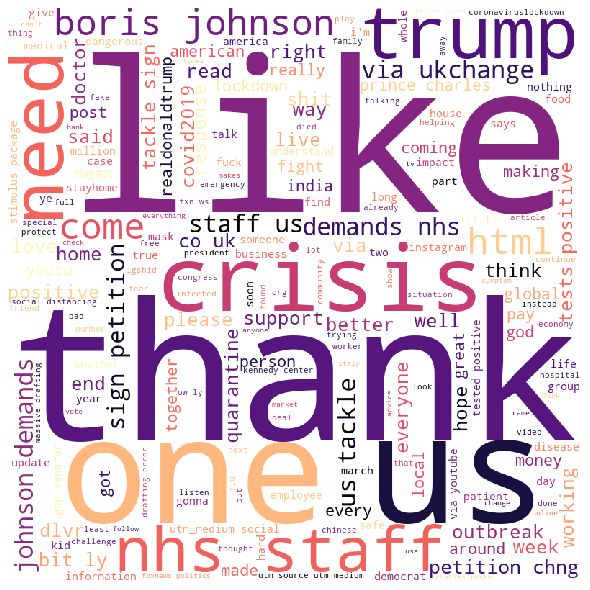

In [128]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap='magma').generate(boris_fix) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [129]:
boris.tweets

0        I said they are better than nothing, not that ...
4        Other than Satan, is there anyone more evil th...
6        JUST IN: COVID-19: Edo Speaker tests positive ...
9        thanks to @glblctzn and @who for having me tak...
17       Coronavirus exposes the problems and pitfalls ...
                               ...                        
57553    A massive THANKS to our NHS & Staff 💙😘 #nhs #c...
57563    @GovRonDeSantis you have failed Florida and hi...
57569    Trump underestimated the power of the new coro...
57577    Russell Westbrook’s (@russwest44) efforts to a...
57589    @realDonaldTrump. You gonna say every news out...
Name: tweets, Length: 10647, dtype: object

In [130]:
comment_words = []
stopwords = stop_words 
  
# iterate through the csv file 
for val in ph.tweets.values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      

    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    
    for words in tokens: 
        comment_words.append(words)
  

In [131]:
ph_fix = ' '.join(comment_words)

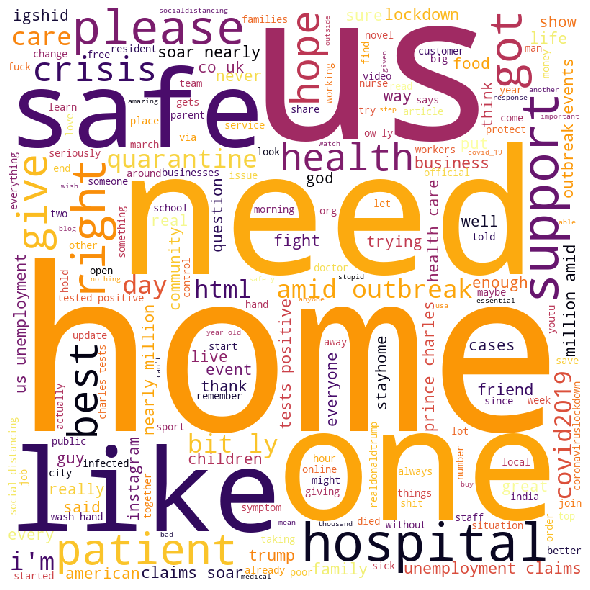

In [132]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap = 'inferno').generate(ph_fix) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

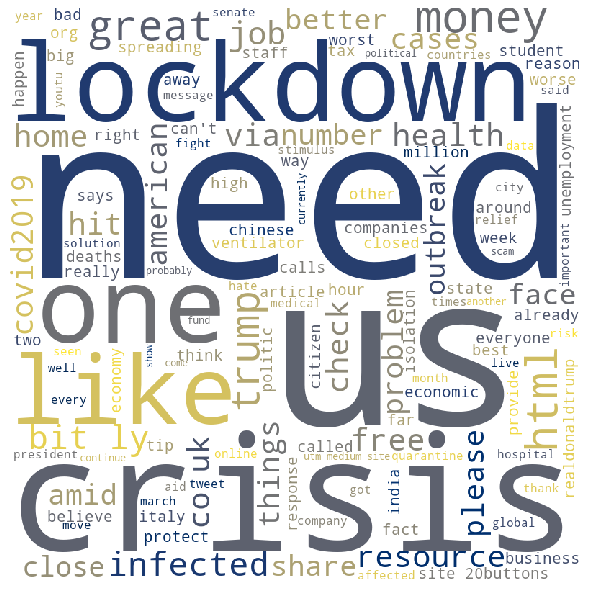

In [142]:

comment_words = ' '
stopwords = stop_words 
  
# iterate through the csv file 
for val in emp.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap='cividis').generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Pickle

In [119]:
# Save a dictionary into a pickle file.
import pickle

In [ ]:
pickle.dump(lda_model, open("lda_5_3456_best", "wb" ))

In [ ]:
pickle.dump(corpus, open("corpus_best", "wb" ))

In [ ]:
pickle.dump(id2word, open("id2word_best", "wb" ))

In [ ]:
pickle.dump(texts, open("texts_best", "wb" ))

In [187]:
lda_model = pickle.load( open( "lda_5_3456_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [188]:
corpus = pickle.load( open( "corpus_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [189]:
id2word = pickle.load( open( "id2word_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [190]:
texts = pickle.load( open( "texts_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [ ]:
plt.hist(texts)